# Definition of libraries


In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F # for functions for calculating loss
import matplotlib.pyplot as plt
import torch.nn as nn
import os
from PIL import Image

In [2]:
# Helper function for accuracy calculation
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Base class for the model
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [3]:
# Convolution block
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)

# ResNet9 architecture
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True)
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True)
        self.conv4 = ConvBlock(256, 512, pool=True)
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [4]:
# Function to load the model
def load_plant_disease_model(model_path, in_channels, num_diseases):
    model = ResNet9(in_channels, num_diseases)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

In [5]:
# Load the saved state_dict
model_path = 'plant-disease-model.pth'
model = load_plant_disease_model(model_path, in_channels=3, num_diseases=38)

C:\Users\victus\AppData\Local\Temp\ipykernel_17056\432277010.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=to

In [6]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Move model to the device
model = model.to(device)

In [8]:
class_names = [
    "Apple___Apple_scab",
    "Apple___Black_rot",
    "Apple___Cedar_apple_rust",
    "Apple___healthy",
    "Blueberry___healthy",
    "Cherry_(including_sour)___healthy",
    "Cherry_(including_sour)___Powdery_mildew",
    "Corn_(maize)___Cercospora_leaf_spot_Gray_leaf_spot",
    "Corn_(maize)___Common_rust_",
    "Corn_(maize)___healthy",
    "Corn_(maize)___Northern_Leaf_Blight",
    "Grape___Black_rot",
    "Grape___Esca_(Black_Measles)",
    "Grape___healthy",
    "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
    "Orange___Haunglongbing_(Citrus_greening)",
    "Peach___Bacterial_spot",
    "Peach___healthy",
    "Pepper,_bell___Bacterial_spot",
    "Pepper,_bell___healthy",
    "Potato___Early_blight",
    "Potato___healthy",
    "Potato___Late_blight",
    "Raspberry___healthy",
    "Soybean___healthy",
    "Squash___Powdery_mildew",
    "Strawberry___healthy",
    "Strawberry___Leaf_scorch",
    "Tomato___Bacterial_spot",
    "Tomato___Early_blight",
    "Tomato___healthy",
    "Tomato___Late_blight",
    "Tomato___Leaf_Mold",
    "Tomato___Septoria_leaf_spot",
    "Tomato___Spider_mites_Two-spotted_spider_mite",
    "Tomato___Target_Spot",
    "Tomato___Tomato_mosaic_virus",
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus"
]


In [9]:
test_dir = "new-plant-diseases-dataset/test/test2"
test = ImageFolder(test_dir, transform=transforms.ToTensor())

In [10]:
test_images = sorted(os.listdir(test_dir + '/test2')) # since images in test folder are in alphabetical order
test_images

['AppleHealthy.JPG',
 'Apple_Cedar_Rust.JPG',
 'Apple_blackRot.JPG',
 'Apple_scab.JPG',
 'BlueberryHealthy.JPG',
 'CherryHealthy.JPG',
 'Cherry_powdery.JPG',
 'CornLeafBlight.JPG',
 'Corn_commonRust.JPG',
 'Corn_leafSpot.JPG',
 'Cornj_healthy.jpg',
 'GrapeHealthy.JPG',
 'Grape_Esca.JPG',
 'Grape_blackRot.JPG',
 'Grape_leafBlight.JPG',
 'Orange(citrus greening).JPG',
 'PeachHealthy.JPG',
 'Peach_Bacteria.JPG',
 'PepperHealthy.JPG',
 'Pepper_Bacterial_spot.JPG',
 'PotatoEarlyBlight.JPG',
 'PotatoHealthy.JPG',
 'PotatoLateBlight.JPG',
 'RaspberryHealthy.JPG',
 'SoyBeanHealthy.JPG',
 'Squash_powdery.JPG',
 'StrawberryHealthy.JPG',
 'StrawberryScorch.JPG',
 'TomatoBLight.JPG',
 'TomatoBacterial.JPG',
 'TomatoHealthy.JPG',
 'TomatoLateBlight.JPG',
 'TomatoMold.JPG',
 'TomatoMosaic.JPG',
 'TomatoSeptoria.JPG',
 'TomatoSpider.JPG',
 'TomatoYellowLeaf.JPG',
 'TomatotargetSpot.JPG']

In [11]:
def to_device(data, device):
    """Move tensor(s) to the chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [12]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return class_names[preds[0].item()]

Label: AppleHealthy.JPG , Predicted: Apple___healthy


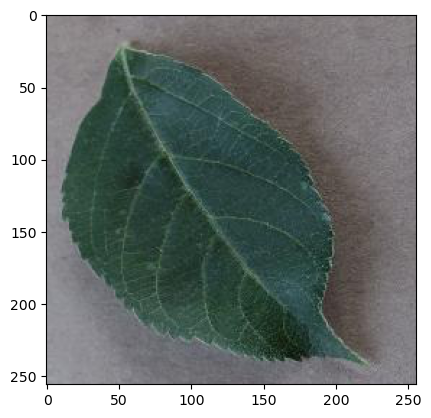

In [183]:
img, label = test[2]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[0], ', Predicted:', predict_image(img, model))

In [184]:
print(len(test_images), len(test))

38 38


In [185]:
# getting all predictions (actual label vs predicted)
for i, (img, label) in enumerate(test):
    print('Label:', test_images[i], ', Predicted:', predict_image(img, model))

Label: AppleHealthy.JPG , Predicted: Apple___healthy
Label: Apple_Cedar_Rust.JPG , Predicted: Apple___Cedar_apple_rust
Label: Apple_blackRot.JPG , Predicted: Apple___Black_rot
Label: Apple_scab.JPG , Predicted: Apple___Apple_scab
Label: BlueberryHealthy.JPG , Predicted: Blueberry___healthy
Label: CherryHealthy.JPG , Predicted: Cherry_(including_sour)___Powdery_mildew
Label: Cherry_powdery.JPG , Predicted: Cherry_(including_sour)___healthy
Label: CornLeafBlight.JPG , Predicted: Corn_(maize)___healthy
Label: Corn_commonRust.JPG , Predicted: Corn_(maize)___Common_rust_
Label: Corn_leafSpot.JPG , Predicted: Corn_(maize)___Cercospora_leaf_spot_Gray_leaf_spot
Label: Cornj_healthy.jpg , Predicted: Corn_(maize)___Northern_Leaf_Blight
Label: GrapeHealthy.JPG , Predicted: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Label: Grape_Esca.JPG , Predicted: Grape___Esca_(Black_Measles)
Label: Grape_blackRot.JPG , Predicted: Grape___Black_rot
Label: Grape_leafBlight.JPG , Predicted: Grape___healthy
Label: